# STOR 566, Homework 4
### Instructor: Yao Li
### Keywords: VAE, GAN
### Due date: Oct 16, 11:55pm
### **Submission Instruction**

- Please download this script and use it to answer the questions in the homework. 
- For submission, please include your code, code output and answers in the script and submit the ipynb file on sakai.
- Please don't modify existing cells. But you can add cells between the exercise statements.
- To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language. For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

### **References:**

- You can follow the setup instructions at [here](https://pytorch.org/get-started/locally/).
- A useful tutorial on learning pytorch by examples at [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).
- Check Pytorch optimization methods at [here](https://pytorch.org/docs/stable/optim.html).
- Check Pytorch DC-GAN tutorial at [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).


### **Evaluation Metrics of Generator:**

- [Fréchet Inception Distance](https://arxiv.org/pdf/1706.08500.pdf): compares the distribution of generated images with the distribution of a set of real images

    - Code Reference: https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/

- [Inception Score](https://arxiv.org/abs/1606.03498): measures two things simultaneously

    - The images have variety (e.g. each image is a different breed of dog)
    - Each image distinctly looks like something (e.g. one image is clearly a Poodle, the next a great example of a French Bulldog)
    - Code Reference: https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/

## Problem 1 (40 points)

In this problem you will practice implementing Variational Auto-Encoder (VAE) on MNIST data set.

**Data.** You will use MNIST digit classification dataset. Pytorch/torchvision has provide a useful dataloader to automatically download and load the data into batches. Code of the data loader has been provided in the template. Please don't modify the data loading part.

In [ ]:
'''
# You need package pytorch-ignite for the last question
# To avoid loading it every time, you can install pytorch-ignite to a path on google drive
import os
from google.colab import drive
drive.mount('/content/drive')
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'
!pip install --target=$pkg_path pytorch-ignite

# Append the path to the sys path to load the pkg without re-installation
import sys
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'
sys.path.append(pkg_path)
import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.metrics import FID, InceptionScore
'''

In [1]:
# Mount your drive
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS' #Please specify the path where you installed torchdata
sys.path.append(pkg_path)

Mounted at /content/drive


In [2]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch.utils.data as td
import random, time
import matplotlib.pyplot as plt
import torchvision
import PIL.Image as Image
import matplotlib.pyplot as plt
import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.metrics import FID, InceptionScore
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchsummary import summary
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
## Data loading code chunk, please don't modify it. 
## However, you can adjust the batch size if you want to.
batch_size = 128

def mnist_loaders(batch_size): 
    data_dir = './data'
    train_data = datasets.MNIST(data_dir, train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                      ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test_data = datasets.MNIST(data_dir, train=False, download=False,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                      ]))
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, 
      shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size, 
      shuffle=False)
    return train_loader, test_loader

train_mnist_loader, test_mnist_loader = mnist_loaders(batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### **Problem Description.** Implement **VAE** with Pytorch on MNIST.

### (a) (5 points) Print the model architecture.

In [ ]:
#Code:

In [4]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [ ]:
VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

### (b) (5 points) Report the hyper-parameters (number of epochs, learning rate, momentum, weight_decay etc).

Answer:

Number of epochs: 50 <br>
Optimization's hyper-parameters are Optim.Adam's default settings: <br>
Learning rate: 0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, foreach=None, maximize=False, capturable=False

### (c) (20 points) Report the **VAE Loss** after every training epoch by generating Loss vs. Epoch plot. Please report at least **10** epochs.

In [ ]:
#Code:

In [ ]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy_with_logits(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_mnist_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
#        if batch_idx % 100 == 0:
#            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch + 1, batch_idx * len(data), len(train_mnist_loader.dataset),
#                100. * batch_idx / len(train_mnist_loader), loss.item() / len(data)))
    
    train_loss /= len(train_mnist_loader.dataset)
    print('Epoch: {} Average train loss: {:.4f}'.format(epoch + 1, train_loss))
    return train_loss

In [ ]:
def test():
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_mnist_loader:
            data = data.cuda()
            recon, mu, log_var = model(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
    
    test_loss /= len(test_mnist_loader.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [ ]:
model = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters())

total_train_loss = []
total_test_loss = []

for epoch in range(50):
    train_loss = train(epoch)
    total_train_loss.append(train_loss)
    test_loss = test()
    total_test_loss.append(test_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 Average train loss: 480.4862
Test set loss: 463.4921
Epoch: 2 Average train loss: 465.5544
Test set loss: 458.8006
Epoch: 3 Average train loss: 462.2822
Test set loss: 456.7746
Epoch: 4 Average train loss: 460.3505
Test set loss: 455.1289
Epoch: 5 Average train loss: 458.8042
Test set loss: 453.8063
Epoch: 6 Average train loss: 457.7301
Test set loss: 452.9808
Epoch: 7 Average train loss: 457.1976
Test set loss: 452.4399
Epoch: 8 Average train loss: 456.7460
Test set loss: 452.1262
Epoch: 9 Average train loss: 456.0507
Test set loss: 451.1842
Epoch: 10 Average train loss: 455.5592
Test set loss: 450.6972
Epoch: 11 Average train loss: 454.8869
Test set loss: 449.9847
Epoch: 12 Average train loss: 454.3908
Test set loss: 449.7823
Epoch: 13 Average train loss: 453.8827
Test set loss: 449.5159
Epoch: 14 Average train loss: 453.3358
Test set loss: 448.4642
Epoch: 15 Average train loss: 452.7826
Test set loss: 447.9280
Epoch: 16 Average train loss: 452.1337
Test set loss: 447.6313
E

In [ ]:
#Plot:

Text(0.5, 1.0, 'Average Train Loss of Every Epoch')

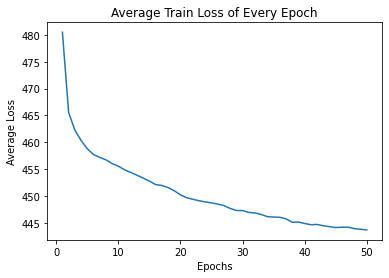

In [ ]:
# Train Loss

plt.plot(range(1,51), total_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Average Train Loss of Every Epoch')

Text(0.5, 1.0, 'Average Test Loss of Every Epoch')

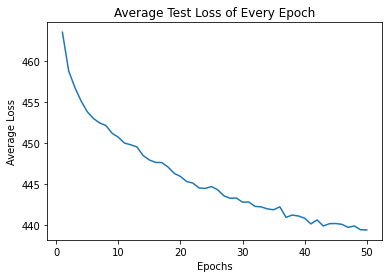

In [ ]:
# Test Loss

plt.plot(range(1,51), total_test_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Average Test Loss of Every Epoch')

### (d) (10 points) Please apply the trained VAE model on a batch (128) of test samples and visualize both the test samples and reconstructed samples. Do the reconstructed samples look good?

In [ ]:
#Code:

Original Images


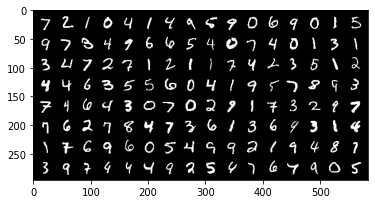

In [ ]:
images, labels = next(iter(test_mnist_loader))
with torch.no_grad():
     print("Original Images")
     test_images = images.cpu()
     test_images = test_images.clamp(0, 1)
     test_images = test_images[:128]
     test_images = torchvision.utils.make_grid(test_images, 16, 8)
     test_images = test_images.numpy()
     test_images = np.transpose(test_images, (1, 2, 0))
     plt.imshow(test_images)
     plt.show()

Reconstructions


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


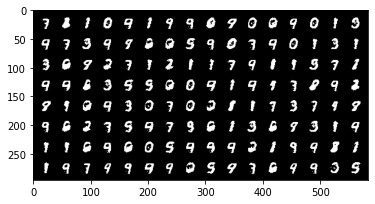

In [ ]:
with torch.no_grad():
     for data, _ in test_mnist_loader:
         data = data.cuda()
         recon, mu, log_var = model(data)
         break

with torch.no_grad():
     print("Reconstructions")
     reconstructions = recon.view(recon.size(0), 1, 28, 28)
     reconstructions = reconstructions.cpu()
     reconstructions = reconstructions.clamp(0, 1)
     reconstructions = reconstructions[:128]
     plt.imshow(np.transpose(torchvision.utils.make_grid(reconstructions, 16, 8).numpy(), (1, 2, 0)))
     plt.show()

Answer:

Comparing between the original graph and reconstructed graph on the first batch (128), my training seems to be acceptable where the accuracty seems to be about 70% ~ 80%. However, for the digit 4, from two figures above, we can find that the model does not deal with it well because in most cases, the model identifies 4 as 9.

## Problem 2 (60 points)

In this problem you will practice implementing DC-GAN on CIFAR10 data set.

**Data.** You will use CIFAR10 classification dataset (10 classes). Pytorch/torchvision has provide a useful dataloader to automatically download and load the data into batches. Code of the data loader has been provided in the template. Please don't modify the data loading part.

In [90]:
## Data loading code chunk, please don't modify it. 
## However, you can adjust the batch size if you want to.
batch_size_cifar = 64

def cifar_loaders(batch_size, shuffle_test=False): 
    data_dir = './data'
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.225, 0.225, 0.225])
    train = datasets.CIFAR10(data_dir, train=True, download=True, 
        transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=transforms.Compose([transforms.ToTensor(), normalize]))
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
        shuffle=shuffle_test, pin_memory=True, drop_last=True)
    return train_loader, test_loader

train_cifar_loader, test_cifar_loader = cifar_loaders(batch_size_cifar)

Files already downloaded and verified


### **Problem Description.** Implement **DC-GAN** with Pytorch on CIFAR10.

### (a) (5 points) Print the model architecture (discriminator and generator).

In [ ]:
#Code:

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(

            nn.ConvTranspose2d(latent_dim, 64*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, x):
        x = self.model(x)
        return x

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(

            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()

        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1).squeeze(1)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
       m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
         m.weight.data.normal_(1.0, 0.02)
         m.bias.data.fill_(0)

In [7]:
latent_dim = 100
modelG = Generator(latent_dim).to(device)
modelG.apply(weights_init)
modelG.to(device)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [9]:
modelD = Discriminator().to(device)
modelD.apply(weights_init)
modelD.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [11]:
summary(modelG, (latent_dim, 1, 1))
summary(modelD, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]           3,072
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 1,068,928
Trainable params: 1,068,928
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

### (b) (20 points) Report the **Generator Loss** and **Discriminator Loss** after every training epoch by generating Loss vs. Epoch plot. Please report at least **10** epochs and include two curves in the same plot with legend.

In [ ]:
#Code:

In [16]:
num_epochs = 10
real_label = 1
fake_label = 0
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
optimizerD = idist.auto_optim(optim.Adam(modelD.parameters(), lr=0.0002, betas=(0.5, 0.999)))
optimizerG = idist.auto_optim(optim.Adam(modelG.parameters(), lr=0.0002, betas=(0.5, 0.999)))

G_losses = []
D_losses = []

for epoch in range(num_epochs):
    gloss = 0
    dloss = 0
    run = 0
    for i, data in enumerate(train_cifar_loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        modelD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = modelD(real_cpu)
        lossD_real = criterion(output, label.view(-1).float())
        lossD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake = modelG(noise)
        label.fill_(fake_label)
        output = modelD(fake.detach())
        lossD_fake = criterion(output, label.float())
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        dloss += lossD.item()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        modelG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = modelD(fake)
        lossG = criterion(output, label.float())
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        gloss += lossG.item()
        run += 1

#        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % 
#              (epoch, num_epochs, i, len(train_cifar_loader), lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
    
    D_losses.append(dloss/run)
    G_losses.append(gloss/run)
    print("Epoch = [{}/{}], Loss_D = {}, Loss_G = {}".format(epoch + 1, num_epochs, dloss/run, gloss/run))

Epoch = [1/10], Loss_D = 0.17616724273394746, Loss_G = 5.830559187532995
Epoch = [2/10], Loss_D = 0.16064638598605305, Loss_G = 5.347327379962367
Epoch = [3/10], Loss_D = 0.46101886312217666, Loss_G = 3.3326791062608097
Epoch = [4/10], Loss_D = 0.4863845287533977, Loss_G = 3.073983186384296
Epoch = [5/10], Loss_D = 0.5093203656318243, Loss_G = 3.0411858263108735
Epoch = [6/10], Loss_D = 0.49191460445942475, Loss_G = 3.0490301376175317
Epoch = [7/10], Loss_D = 0.412412659972525, Loss_G = 3.4484790809204817
Epoch = [8/10], Loss_D = 0.19403263639606289, Loss_G = 4.091235113139634
Epoch = [9/10], Loss_D = 0.3742659436276807, Loss_G = 4.261073967636637
Epoch = [10/10], Loss_D = 0.025396687900135412, Loss_G = 5.501299184606508


In [ ]:
#Plot:

Text(0.5, 1.0, 'Average Generator Loss of Every Epoch')

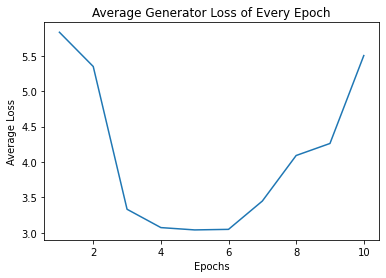

In [17]:
# Generator Loss

plt.plot(range(1,11), G_losses)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Average Generator Loss of Every Epoch')

Text(0.5, 1.0, 'Average Discriminator Loss of Every Epoch')

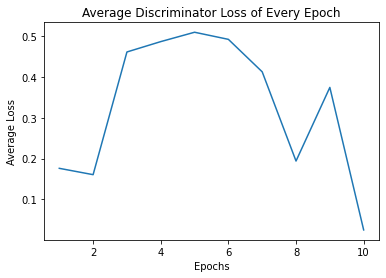

In [18]:
# Discriminator Loss

plt.plot(range(1,11), D_losses)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Average Discriminator Loss of Every Epoch')

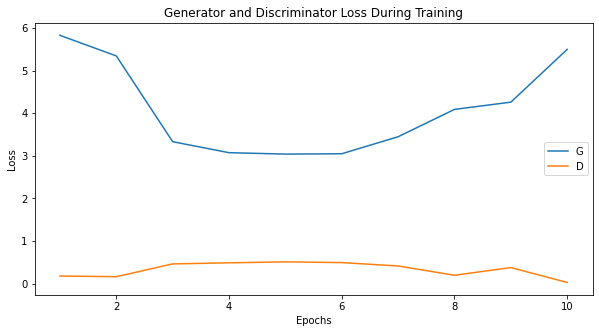

In [19]:
# Generator Loss and Discriminator Loss

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(range(1,11), G_losses, label="G")
plt.plot(range(1,11), D_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### (c) (10 points) Please use the trained DC-GAN model to generate a batch (64) new samples and visualize the generated samples. How do they look? Do they look like real samples?

The generated new samples do not look like real samples; instead, they look vague and somewhat mosaic. That is, the generated new samples seems to be the mosaic form of real samples.

In [ ]:
#Code:

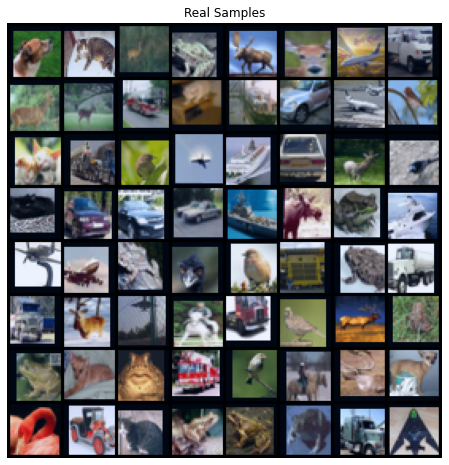

In [106]:
real_batch = next(iter(train_cifar_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Samples")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

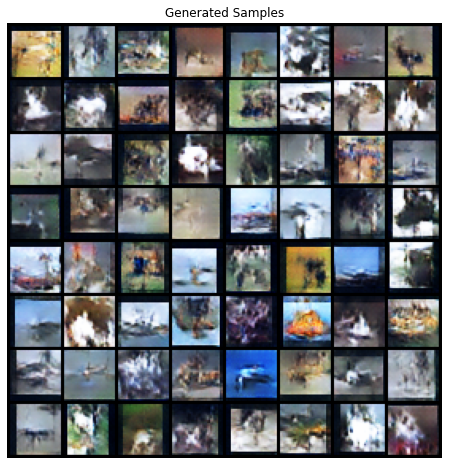

In [107]:
with torch.no_grad():
     fake = modelG(fixed_noise).detach().cpu()

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Samples")
plt.imshow(np.transpose(torchvision.utils.make_grid(fake.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### (d) (25 points) Please evaluate the trained DC-GAN model using Fréchet Inception Distance (FID) and Inception Score (IS) on the testset. 

In [ ]:
#Code:

In [91]:
modelG = idist.auto_model(Generator(latent_dim))
modelD = idist.auto_model(Discriminator())
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=idist.device())
optimizerD = idist.auto_optim(optim.Adam(modelD.parameters(), lr=0.0002, betas=(0.5, 0.999)))
optimizerG = idist.auto_optim(optim.Adam(modelG.parameters(), lr=0.0002, betas=(0.5, 0.999)))
batch_size = 64

In [92]:
real_label = 1
fake_label = 0

def training_step(engine, data):
    # Set the models for training
    modelG.train()
    modelD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    modelD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = modelD(real).view(-1)
    # Calculate loss on all-real batch
    lossD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    lossD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, latent_dim, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = modelG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = modelD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    lossD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    lossD_fake.backward()
    # Compute loss of D as sum over the fake and the real batches
    lossD = lossD_real + lossD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    modelG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = modelD(fake).view(-1)
    # Calculate G's loss based on this output
    lossG = criterion(output3, label)
    # Calculate gradients for G
    lossG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : lossG.item(),
        "Loss_D" : lossD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

trainer = Engine(training_step)

In [93]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
       nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
       nn.init.normal_(m.weight.data, 1.0, 0.02)
       nn.init.constant_(m.bias.data, 0)

In [94]:
@trainer.on(Events.STARTED)
def init_weights():
    modelD.apply(initialize_fn)
    modelG.apply(initialize_fn)

In [95]:
G_losses = []
D_losses = []

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

In [96]:
img_list = []

@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
         fake = modelG(fixed_noise).cpu()
    img_list.append(fake)

In [97]:
fid_metric = FID(device=idist.device())
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

In [98]:
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

def evaluation_step(engine, batch):
    with torch.no_grad():
         noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
         modelG.eval()
         fake_batch = modelG(noise)
         fake = interpolate(fake_batch)
         real = interpolate(batch[0])
         return fake, real

In [99]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [100]:
fid_values = []
is_values = []

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_cifar_loader, max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/10] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [101]:
from ignite.metrics import RunningAverage
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [102]:
from ignite.contrib.handlers import ProgressBar
ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

In [103]:
def training(*args):
    trainer.run(train_cifar_loader, max_epochs=10)

In [104]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

2022-10-16 21:49:19,077 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2022-10-16 21:49:19,079 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7fbf6ed68320>' in 1 processes


[1/782]   0%|           [00:00<?]

[1/156]   1%|           [00:00<?]

Epoch [1/10] Metric Scores
*   FID : 0.038940
*    IS : 1.441284


[1/782]   0%|           [00:00<?]

[1/156]   1%|           [00:00<?]

Epoch [2/10] Metric Scores
*   FID : 0.062223
*    IS : 1.707367


[1/782]   0%|           [00:00<?]

[1/156]   1%|           [00:00<?]

Epoch [3/10] Metric Scores
*   FID : 0.039092
*    IS : 1.622475


[1/782]   0%|           [00:00<?]

[1/156]   1%|           [00:00<?]

Epoch [4/10] Metric Scores
*   FID : 0.047522
*    IS : 1.756889


[1/782]   0%|           [00:00<?]

[1/156]   1%|           [00:00<?]

Epoch [5/10] Metric Scores
*   FID : 0.042747
*    IS : 1.754238


[1/782]   0%|           [00:00<?]

[1/156]   1%|           [00:00<?]

Epoch [6/10] Metric Scores
*   FID : 0.042311
*    IS : 1.740347


[1/782]   0%|           [00:00<?]

[1/156]   1%|           [00:00<?]

Epoch [7/10] Metric Scores
*   FID : 0.046522
*    IS : 1.748734


[1/782]   0%|           [00:00<?]

[1/156]   1%|           [00:00<?]

Epoch [8/10] Metric Scores
*   FID : 0.045648
*    IS : 1.744250


[1/782]   0%|           [00:00<?]

[1/156]   1%|           [00:00<?]

Epoch [9/10] Metric Scores
*   FID : 0.048250
*    IS : 1.791021


[1/782]   0%|           [00:00<?]

[1/156]   1%|           [00:00<?]

2022-10-16 22:22:46,894 ignite.distributed.launcher.Parallel INFO: End of run
2022-10-16 22:22:46,903 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


Epoch [10/10] Metric Scores
*   FID : 0.043785
*    IS : 1.767266


Since the FID and IS scores are both low, the model seems acceptable.